# Laboratorio 4: KNN

Clase de Alexandre Gramfort, Anne Sabourin, y Joseph Salmon

Actualizado por Valentin Barriere

Integrantes: Adolfo Ignacio Rojas Valenzuela, Emilia Chávez Salamanca

## Recordatorios  

### Definiciones y Notación

Recordamos aquí el marco de trabajo de la clasificación supervisada y presentamos las notaciones que se utilizarán a lo largo del laboratorio.

- $\mathcal{Y}$ es el conjunto de etiquetas de los datos. Aquí trabajamos con un número arbitrario $L$ de clases, y elegimos $\mathcal{Y} = \{1,\dots, L\}$ para representar las $L$ etiquetas posibles. El caso de clasificación binaria corresponde a $L=2$.  

- $\mathbf{x} = (x_1,\dots,x_p)^\top \in \mathcal{X} \subset \mathbb{R}^p$ es una observación, un ejemplo o un punto de muestra. La $j$-ésima coordenada de $\mathbf{x}$ es el valor tomado por la $j$-ésima variable (característica).  

- $\mathcal{D}_n = \{(\mathbf{x}_i , y_i), i=1,\dots, n\}$ es el conjunto de entrenamiento que contiene los $n$ ejemplos y sus etiquetas.  

- Existe un modelo probabilístico que gobierna la generación de nuestras observaciones a través de las variables aleatorias $X$ e $Y$: $\forall i \in \{1,\dots,n\},  (\mathbf{x}_i , y_i) \stackrel{i.i.d.}{\sim} (X,Y)$.  

- Nuestro objetivo es construir, a partir del conjunto de entrenamiento $\mathcal{D}_n$, una función llamada **clasificador**, $\hat{f}:\mathcal{X} \rightarrow \mathcal{Y}$, que asigne a un nuevo punto $\mathbf{x}_{\text{nuevo}}$ una etiqueta $\hat{f}(\mathbf{x}_{\text{nuevo}})$.

### Generación de Datos Artificiales  

En esta sección, consideramos observaciones descritas en dos dimensiones (para facilitar la visualización), lo que significa que $p=2$ en el formalismo anterior. Utilizamos funciones que generan conjuntos de datos artificiales del script `tp_knn_source.py`, con modificaciones únicamente en los valores de las etiquetas.  

1. **Estudia las funciones `rand_tri_gauss`, `rand_clown` y `rand_checkers`.**  
   - ¿Qué devuelven estas funciones?  
   - ¿A qué corresponde la última columna?

In [429]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette="mako")

from tp_knn_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d,
                           frontiere)

############################################################################
#     Generación de datos
############################################################################

n = 100
mu = [1., 1.]
sigma = [1., 1.]
rand_gauss(n, mu, sigma)

n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
data1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
data2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
data3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
data4 = rand_checkers(n1, n2, sigma)

R: Las 3 funciones generan conjuntos de datos aleatorios con clases. Cada clase está distribuido de forma distinta.

Las funciones reciben argumentos `n_i` que indican la cantidad de elementos a generar dentro de cada clase. Además reciben listas de parámetros, donde el $i$-ésimo elemento la lista será un parámetro para el componente $i$ de cada dato.

Los datos se mezclan de forma aleatoria y la tercera columna indica a qué clase pertenece.

- `rand_tri_gauss` genera un conjunto de datos con 3 clases donde cada clase tiene sus datos siguiendo una distribución gaussiana (con los parámetros entregados).
- `rand_clown` genera un conjunto de datos con 2 clases donde cada clase sigue una distribución distinta con ruido gaussiano, la primera se trata de una nube cuadrática centrada en 0 y la segunda de una nube gaussiana desplazada
- `rand_checkers` genera un conjunto de datos con 3 clases distribuídas en clusters con ruido gaussiano

2. Utiliza la función `plot_2d` para visualizar los conjuntos de datos.

#### `rand_bi_gauss`

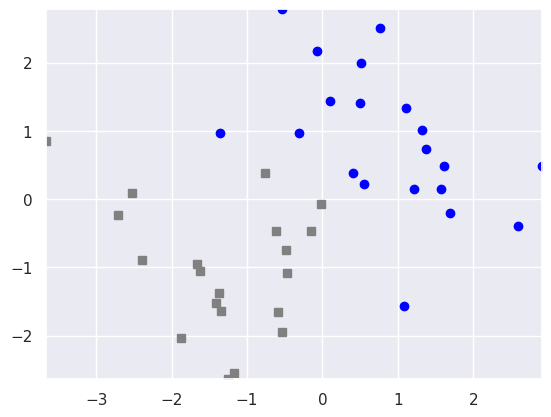

In [430]:
plot_2d(data1[:,:2], data1[:,2])

#### `rand_tri_gauss`

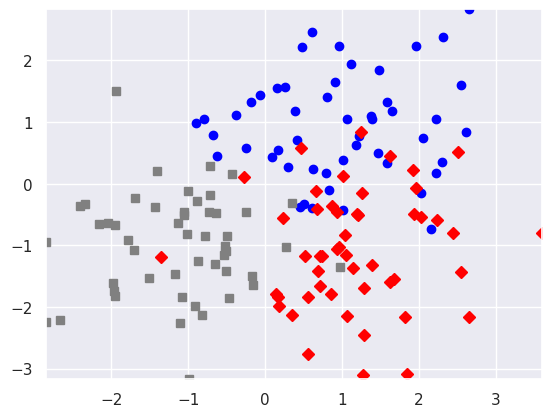

In [431]:
plot_2d(data2[:,:2], data2[:,2])

#### `rand_clown`

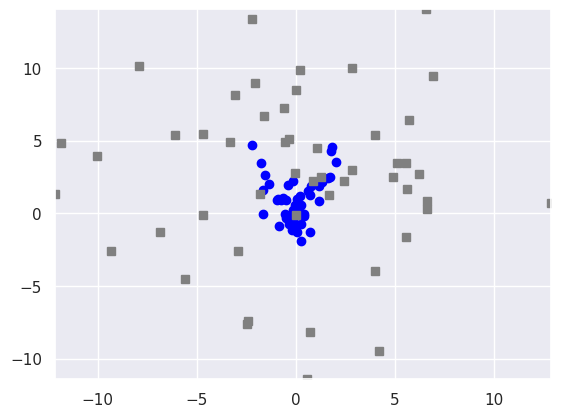

In [432]:
plot_2d(data3[:,:2], data3[:,2])

#### `rand_checkers`

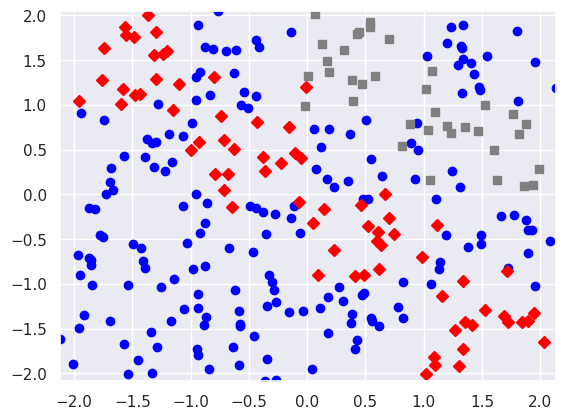

In [433]:
plot_2d(data4[:,:2], data4[:,2])

## El Método de los $k$-Vecinos Más Cercanos  

### Enfoque Intuitivo  

El algoritmo de los $k$-vecinos más cercanos (**$k$-nn**) es un método intuitivo y fácil de ajustar para abordar problemas de clasificación con cualquier número de etiquetas.  

El principio del algoritmo es simple: para cada nuevo punto $\mathbf{x}$, primero determinamos el conjunto de sus $k$ vecinos más cercanos entre los puntos de entrenamiento, que denotamos como $V_k(\mathbf{x})$ (por supuesto, debemos elegir $1 \leq k \leq n$ para que esto tenga sentido). La clase asignada al nuevo punto $\mathbf{x}$ es entonces la **clase mayoritaria** dentro del conjunto $V_k(\mathbf{x})$. En la siguiente figura se muestra una ilustración del método para el caso de tres clases.

### Ilustración

![Visualización](knn.png "Ejemplo de cómo funciona el método de los k-vecinos más cercanos para valores de parámetro k=5 y k=11. Consideramos tres clases, L=3, representadas respectivamente en negro (y=1), gris (y=2) y blanco (y=3)")

Ejemplo de cómo funciona el método de los k-vecinos más cercanos para valores de parámetro k=5 y k=11. Consideramos tres clases, L=3, representadas respectivamente en negro (y=1), gris (y=2) y blanco (y=3)

1. Proponga una versión adaptada de este método para **regresión**, *es decir*, cuando las observaciones tienen valores reales: $\mathcal{Y} = \mathbb{R}$.

R: Si asumimos que nuestro modelo quiere reproducir el comportamiento de una función regular donde cada observación $\mathbf{x_{nuevo}}$ está dentro del rango del set de entrenamiento (reducirnos a la interpolación local para hacer nuestras predicciones) podemos calcular la distancia de dicho dato $\mathbf{x_{nuevo}}$ respecto a cada dato del set de entrenamiento, escoger los $k$ puntos con menor distancia y asignarle a nuestra predicción el promedio de las imagenes $\mathbf{y}$ de los $k$ puntos elegidos, alternativamente podríamos sacar el promedio ponderado con pesos relativos al rango/distancia de cada vecino

## Enfoque Formal

Para definir con precisión el método, primero debemos elegir una distancia $d: \mathbb{R}^p \times \mathbb{R}^p \rightarrow \mathbb{R}$. Para un nuevo punto $\mathbf{x}$, definimos entonces el conjunto de sus $k$-vecinos más cercanos $V_k(\mathbf{x})$ usando esta distancia. Procedemos de la siguiente manera:

Para cada $\mathbf{x} \in \mathbb{R}^p$ y cada $i = 1, \ldots, n$, denotamos $d_i(\mathbf{x})$ como la distancia entre $\mathbf{x}$ y $\mathbf{x}_i$:
$$
d_i(\mathbf{x}) = d(\mathbf{x}_i, \mathbf{x}).
$$

Definimos el estadístico de primer orden $r_1(\mathbf{x})$ como el índice del vecino más cercano a $\mathbf{x}$ entre $\mathbf{x}_1, \ldots, \mathbf{x}_n$, es decir:
$$
r_1(\mathbf{x}) = i^* \quad \text{si y solo si} \quad d_{i^*}(\mathbf{x}) = \min_{1 \le i \le n} d_i(\mathbf{x}).
$$

> **Nota**  
> Si hay múltiples candidatos para el mínimo anterior, los empates se resuelven arbitrariamente (generalmente al azar).

Por inducción, podemos definir el rango $r_k(\mathbf{x})$ para cualquier entero $1 \leq k \leq n$:
$$
r_k(\mathbf{x}) = i^* \quad \text{si y solo si} \quad
d_{i^*}(\mathbf{x}) = \min_{\substack{1 \le i \le n \\ i \notin \{r_1, \ldots, r_{k-1}\}}} d_i(\mathbf{x}).
$$

El conjunto de los $k$-vecinos más cercanos de $\mathbf{x}$ se escribe entonces:
$$
V_k(\mathbf{x}) = \{ \mathbf{x}_{r_1}, \dots, \mathbf{x}_{r_k} \}.
$$

Finalmente, la decisión para clasificar el punto $\mathbf{x}$ se toma por votación mayoritaria, resolviendo el siguiente problema:

$$
\hat{f}_k(\mathbf{x}) \in \arg\max_{y \in \mathcal{Y}} \left( \sum_{j=1}^k \mathbb{1}_{\{Y_{r_j} = y\}} \right).
$$

El módulo `sklearn.neighbors` de **scikit-learn** implementa métodos de clasificación y regresión basados en los $k$-vecinos más cercanos.  
Consulta la documentación: [scikit-learn.neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

2. Completa la clase `KNNClassifier`.  
   Verifica la exactitud de los resultados comparando con la clase `KNeighborsClassifier` de **scikit-learn**.  
   Propón **tu propio método de comparación**.


In [443]:
from sklearn.base import BaseEstimator, ClassifierMixin
import scipy.stats

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1, weights=lambda x: np.ones(x.shape)):
        self.n_neighbors = n_neighbors
        # Weights para la P5
        self.weights_function = weights

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        n_samples, n_features = X.shape
        def d(a, b):
            return np.sqrt(
                ((a - b) ** 2).sum()
            )

        result = np.zeros(len(X))
        for i, x in enumerate(X):
            distances = np.zeros(len(self.X_))
            for j, fitted_x in enumerate(self.X_):
                distances[j] = d(x, fitted_x)

            # se obtienen los k puntos más cercanos
            range_ = distances.argsort()[:self.n_neighbors]
            range_classes = self.y_[range_]
            # se calcula el peso para todos los puntos en el rango
            weights = self.weights_function(distances[range_])
            classes = np.unique(self.y_)
            votes = np.zeros(len(classes))
            # para cada clase se suman los pesos de cada punto en dicha clase
            for j, c in enumerate(classes):
                votes[j] = weights[range_classes == c].sum()
            # el resultado tendrá la clase con más votos
            result[i] = classes[votes.argmax()]
            # result[i] = scipy.stats.mode(self.y_[range_])[0]

        return result

from sklearn import neighbors

# Conjunto de datos 2
X_train = data2[::2, :2]
Y_train = data2[::2, 2]
X_test = data2[1::2, :2]
Y_test = data2[1::2, 2]

custom_knn = KNNClassifier(4).fit(X_train, Y_train)
scikit_knn = neighbors.KNeighborsClassifier(4).fit(X_train, Y_train)

Y_pred_custom = custom_knn.predict(X_test)
Y_pred_scikit = scikit_knn.predict(X_test)

# De ahora en adelante utilice la implementación de scikit-learn
plt.ion()

<span style="color: yellow">NOTE:</span> Arriba se hace parte de la P5 también, por eso lo de weights

#### Diferencia simétrica entre clases predichas por cada modelo
Se usará la diferencia simétrica entre las clases predichas por cada modelo para medir qué tanto se parecen. Si los elementos en la diferencia simétrica son pocos, es porque los modelos predijeron clases similares para los datos.

Se hará esto para cada posible valor para $k$ o `n_neighbors`.

In [435]:
total_differences = 0
for n_neighbors in range(1, len(X_train) + 1):
    custom_knn = KNNClassifier(n_neighbors).fit(X_train, Y_train)
    scikit_knn = neighbors.KNeighborsClassifier(n_neighbors).fit(X_train, Y_train)
    
    Y_pred_custom = custom_knn.predict(X_test)
    Y_pred_scikit = scikit_knn.predict(X_test)
    ind = np.arange(len(Y_pred_custom))
    X_pred_custom = [
        set(ind[Y_pred_custom == y])
        for y in [1, 2, 3]
    ]
    X_pred_scikit = [
        set(ind[Y_pred_scikit == y])
        for y in [1, 2, 3]
    ]
    # differences = cantidad de elementos que difieren en total
    differences = 0
    for X_pred_custom_i, X_pred_scikit_i in zip(X_pred_custom, X_pred_scikit):
        differences += len(X_pred_custom_i.symmetric_difference(X_pred_scikit_i))
    total_differences += differences

In [436]:
total_differences

0

Ya que no hay diferencias en las predicciones, se puede concluir que los modelos son equivalentes, al menos para esta muestra de datos generados.

Como los modelos siguen el mismo algoritmo teórico, se concluye que serán equivalentes para cualquier set de datos.

**Nota**: Para ahorrar en tiempo de cómputo, deberás utilizar la implementación de **scikit-learn**!

3. Ejecuta el algoritmo de clasificación en los tres conjuntos de datos de ejemplo,  
   utilizando la **distancia euclidiana clásica**:  
   $$
   d(\mathbf{x}, \mathbf{v}) = \| \mathbf{x} - \mathbf{v} \|_2
   $$

Notar que en los gráficos de datos con 2 clases, el color rojo en la frontera verifican los puntos blancos. Es decir, los puntos en vez de ser rojos son blancos. 

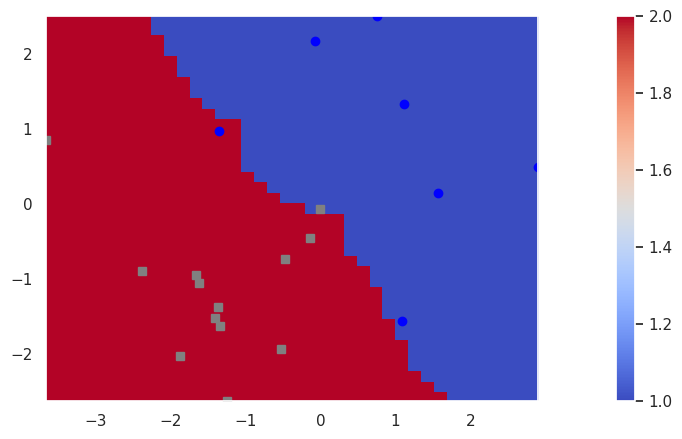

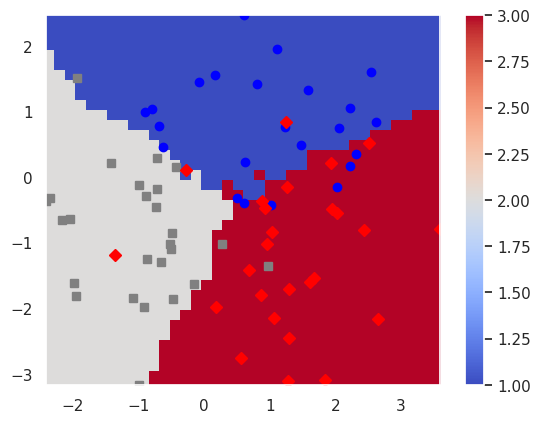

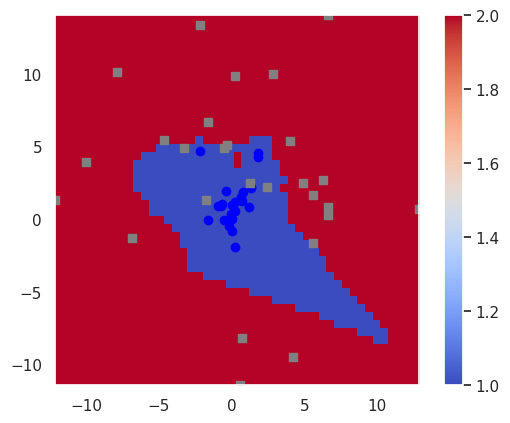

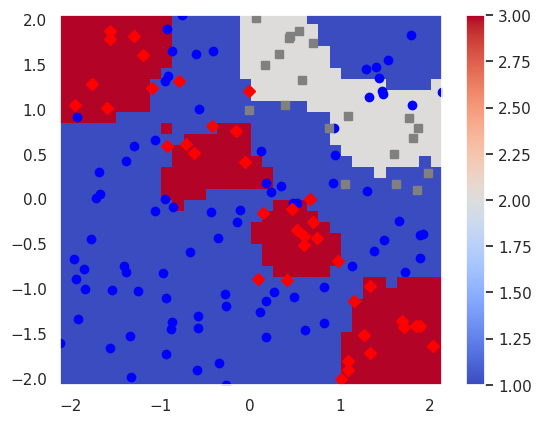

In [444]:
n_neighbors = 5  # la k en k-NN
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

plt.figure(figsize=(20, 5))
for i, data in enumerate([data1, data2, data3, data4]):
    X_train_i = data[::2, :2]
    Y_train_i = data[::2, 2]
    X_test_i = data[1::2, :2]
    Y_test_i = data[1::2, 2]
    knn.fit(X_train_i, Y_train_i)

    frontiere(knn.predict, X_test_i)
    plot_2d(X_test_i, Y_test_i)
    plt.grid(False)
    plt.show()

4. Varía el número $k$ de vecinos considerados.  
   - ¿En qué se convierte el método en los casos extremos cuando $k=1$? ¿Y cuando $k=n$?  
   - Muestra estos casos en los datos estudiados.  
   - ¿En qué casos el **límite de decisión es complejo**? ¿**simple**?

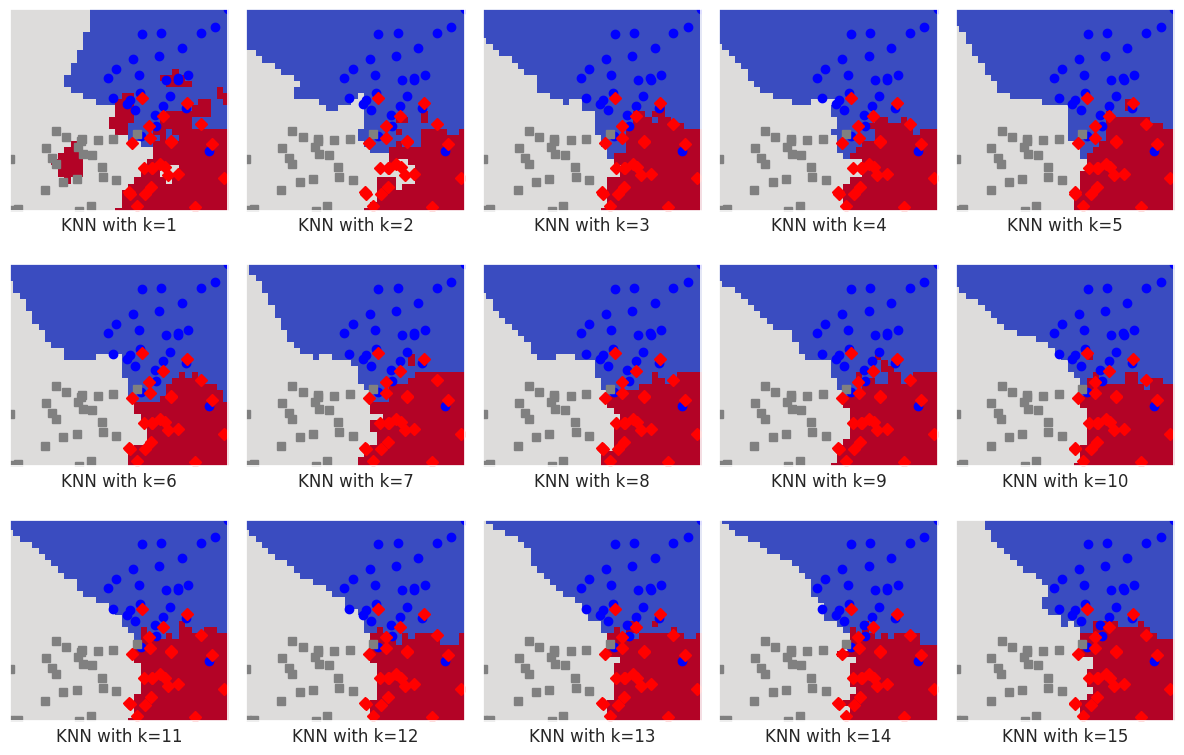

In [438]:
plt.figure(3, figsize=(12, 8))
for n_neighbors in range(1, 16):
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

    knn.fit(X_test, Y_test)
    
    plt.subplot(3, 5, n_neighbors)
    plt.xlabel('KNN with k=%d' % n_neighbors)
    plot_2d(X_train, Y_train)
    frontiere(knn.predict, X_test, step=50, tiny=True)
plt.tight_layout()

R: Para el caso de $k=1$ el modelo tenderá a sufrir de overfitting al ser muy susceptible al ruido y outliers, terminamos con fronteras de decisión muy complejas/irregulares. En el otro extremo $k=n$ obtenemos un modelo que tenderá a sufrir de underfitting, tan simple que asigna la misma clase (o valor promedio) a todos los puntos, no captura patrones e ignora clusters locales (incluso peor si el conjunto de entrenamiento está desbalanceado)

5. Una variante ampliamente utilizada consiste en **ponderar los votos** del j-ésimo vecino mediante la siguiente fórmula:  
   $$
   e^{-d_j^2 / h}
   $$
   (donde $h$ controla el nivel de ponderación).

   Esto equivale a reemplazar la ecuación de votación mayoritaria por:

   $$
   \hat{f}_k(\mathbf{x}) \in \arg\max_{y \in \mathcal{Y}} \left( \sum_{j=1}^k \exp\left(-\frac{d_j^2}{h}\right) \mathbb{I}_{\{Y_{r_j} = y\}} \right)
   $$

   - Implementa esta variante en tu clase `KNNClassifier`
   - También impleméntala usando scikit-learn pasando el parámetro `weights` al constructor de `KNeighborsClassifier`
   - Puedes inspirarte en la función `_weight_func` de las pruebas de scikit-learn: [Enlace a prueba de scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/tests/test_neighbors.py)

   - **Prueba el impacto de la elección de $h$** en los límites de clasificación

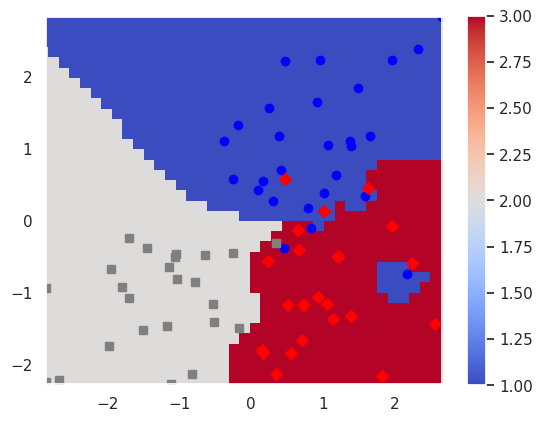

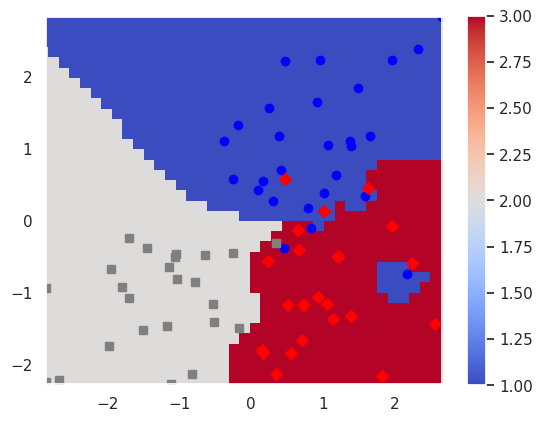

In [456]:
def weights(dist):
    """
    Devuelve un array de pesos, que disminuyen exponencialmente al cuadrado
    de la distancia.

    Parámetros
    ----------
    dist : un array unidimensional de distancias.

    Retorna
    -------
    weight : array del mismo tamaño que dist
    """
    h=0.1
    return np.exp(-dist ** 2 / h)

n_neighbors = 5
wknn_custom = KNNClassifier(n_neighbors=n_neighbors, weights=weights)
wknn_custom.fit(X_train, Y_train)
plt.figure(4)
plot_2d(X_train, Y_train)
frontiere(wknn_custom.predict, X_train, step=50)
plt.grid(False)
plt.show()
# print(wknn_custom.predict(X_test))

wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
wknn.fit(X_train, Y_train)
plt.figure(4)
plt.grid(False)
plot_2d(X_train, Y_train)
frontiere(wknn.predict, X_train, step=50)
# print(wknn.predict(X_test))

Comente sus resultados

R: Jugando con h podemos ver cómo para valores pequeños hay fronteras locales/aisladas para los puntos "ruidosos", esto porque al favorecer tanto a los vecinos con menor distancia terminamos haciendo sobreajuste, en el caso contrario con h tendiendo a 1 se dan fronteras simples puesto que la ponderación se termina asimilando a la uniforme, para este caso no es tan común ver fronteras locales provocadas por outliers y ruido

6. ¿Cuál es la **tasa de error** en tus datos de entrenamiento (es decir, la proporción de errores cometidos por el clasificador) cuando $k = 1$?

    Use el método [`score()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score)

In [402]:
knn = neighbors.KNeighborsClassifier(1)
knn.fit(X_train, Y_train)
print(knn.score(X_train, Y_train))

wknn = neighbors.KNeighborsClassifier(1, weights=weights)
wknn.fit(X_train, Y_train)
print(wknn.score(X_train, Y_train))

1.0
1.0


R: Tanto en el caso unweighted como weighted es 1, porque cada punto se clasifica usando su vecino más cercano, que en el entrenamiento es el mismo punto. Luego el modelo le asignará la misma clase que tenía al entrenar.

7. Grafica las **curvas de error** en función de $k$ para uno de los conjuntos de datos,  
   con tamaños de muestra $n$ que varíen entre $100$, $500$ y $1000$.

   - ¿Cuál es el mejor valor de $k$?
   - ¿Es siempre el mismo para los diferentes conjuntos de datos?
   - Asegúrate de evaluar el error en los **datos de prueba**.
   - Puedes utilizar la clase proporcionada `ErrorCurve`.

Tiempo de generación y entrenamiento con n = 100: 1.02 segundos
Tiempo de generación y entrenamiento con n = 500: 4.52 segundos
Tiempo de generación y entrenamiento con n = 1000: 9.02 segundos


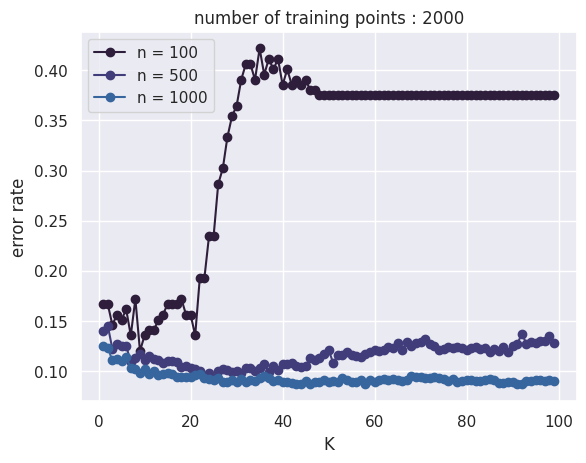

In [403]:
# Preparar
sigma = 0.1
range_n_samples = [100, 500, 1000]
k_range = range(1, 100)

# Función auxiliar para generar los conjuntos de entrenamiento y prueba
def generate_train_test(n, sigma):
    data = rand_checkers(n, n, sigma)
    X_train, Y_train = data[:, :2], data[:, 2]
    data_test = rand_checkers(n, n, sigma)
    X_test, Y_test = data_test[:, :2], data_test[:, 2]
    return X_train, Y_train, X_test, Y_test

from tp_knn_source import ErrorCurve
import time

for n in range_n_samples:
    inicio = time.time()
    
    X_train, Y_train, X_test, Y_test = generate_train_test(n, sigma)
    error_curve = ErrorCurve(k_range)
    error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
    
    termino = time.time()
    
    error_curve.plot(label=f"n = {n}")
    plt.legend()
    print(f"Tiempo de generación y entrenamiento con n = {n}: {termino - inicio:.2f} segundos")

R: No podemos saber los k óptimos exactos para cada n puesto que van cambiando segun el muestreo de rand_checkers

8. En tu opinión, ¿cuáles son las **ventajas** y **desventajas** del método de los vecinos más cercanos?  
   - ¿Tiempo de cálculo?  
   - ¿Escalabilidad?  
   - ¿Interpretabilidad?

R: Ya que se trata de un algoritmo del tipo lazy learner (necesita recuperar y operar con todo el dataset de entrenamiento para cada predicción que se desee hacer) es muy costoso computacionalmente, lo cual lo hace poco efectivo a medida de que crece la cantidad de datos y/o dimensiones, también es sensible a los hiperparámetros $k$ y la distancia (esto puede influir en perder patrones locales o no poder trabajar de manera óptima con vectores sparse). Lo bueno es que es fácil de implementar e interpretar (especialmente útil en tareas de clasificación supervisada)

9. Aplica el método al conjunto de datos **`digits`** con diferentes elecciones de $k \geq 1$. 

    Consulta: [plot_digits_classification.py — scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)

<class 'sklearn.utils._bunch.Bunch'>
Score : 0.9254727474972191


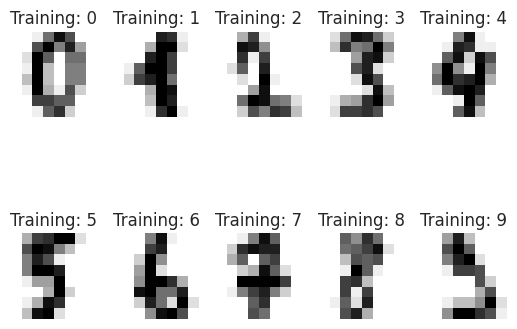

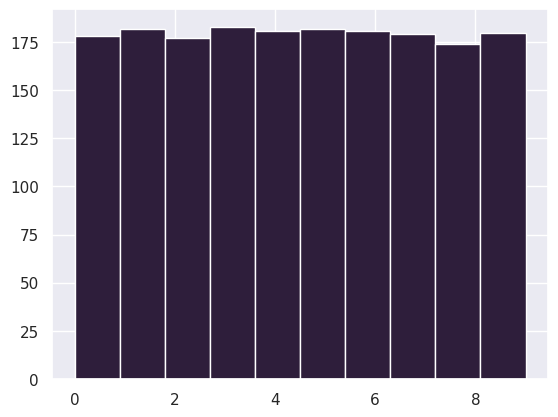

In [417]:
# import sklearn
from sklearn import datasets

# El conjunto de datos de dígitos
digits = datasets.load_digits()

print(type(digits))
# Un Bunch es una subclase de 'dict' (dictionary)
# help(dict)
# vea también "http://docs.python.org/2/library/stdtypes.html#mapping-types-dict"

plt.close(7)
plt.figure(7)
for index, (img, label) in enumerate(list(zip(digits.images, digits.target))[10:20]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: %i' % label)

plt.figure()
plt.hist(digits.target)

n_samples = len(digits.data)

X_train = digits.data[:n_samples // 2]
Y_train = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]

knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, Y_train)

score = knn.score(X_test, Y_test)
print('Score : %s' % score)

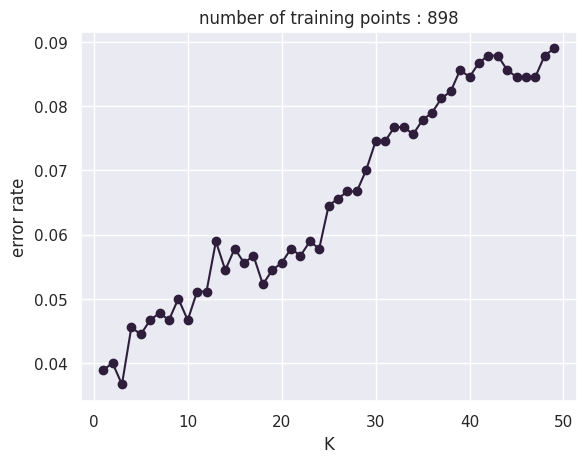

In [418]:
k_range = range(1, 50)
# from tp_knn_source import ErrorCurve
error_curve = ErrorCurve(k_range)
error_curve.fit_curve(X_train, Y_train, X_test, Y_test)
error_curve.plot()

10. Grafica la **matriz de confusión** $\left( \mathbb{P}\{Y = i, C_k(X) = j\} \right)_{i, j}$ asociada al clasificador $C_k$. 

    Para manejar estas matrices con scikit-learn, consulta: [Ejemplo de matriz de confusión — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

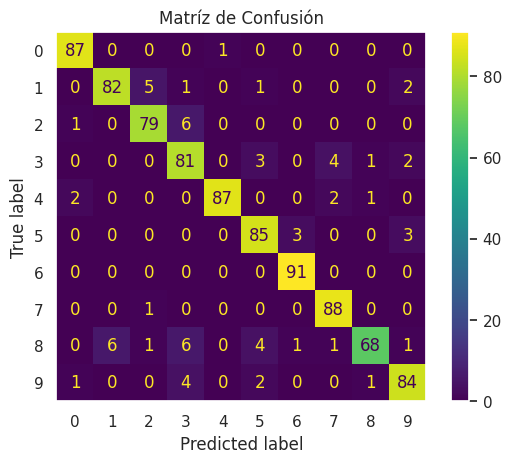

In [419]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = knn.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.title('Matríz de Confusión')
plt.show()

11. Propón un **método para seleccionar $k$** e impleméntalo. Puedes utilizar la clase proporcionada `LOOCurve`.

El k óptimo dado k_range es: 1


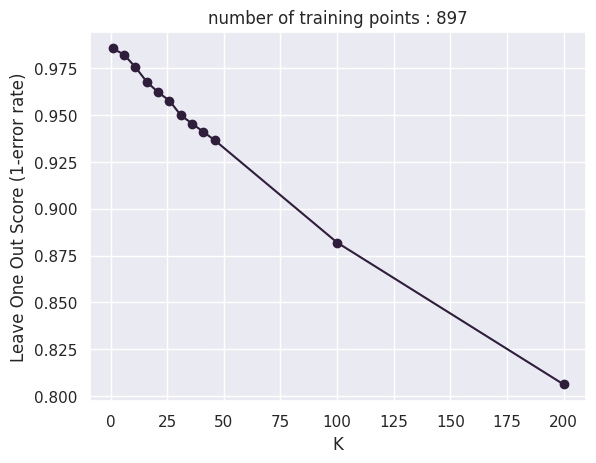

In [427]:
# Revise la clase 'LOOCurve', en el archivo fuente
from tp_knn_source import LOOCurve

loo_curve = LOOCurve(k_range=list(range(1, 50, 5)) + list(range(100, 300, 100)))

loo_curve.fit_curve(X_train, Y_train)
# Encontrar el k óptimo
k_optimo = loo_curve.k_range[
                        np.argmax(loo_curve.cv_scores)
                    ]
print(f"El k óptimo dado k_range es: {k_optimo}")
loo_curve.plot()

¿De qué forma elegiría usando `LOOCurve` k?

R: Como en el ítem previo implementamos una forma de seleccionar $k$ en base a la clase LOOCurve, para encontrar el óptimo podemos jugar con un k_range que siga una secuencia de step 1 (ya que para los dígitos vimos que no hace falta un k alto para hacer una buena predicción)